# Spectrum simulation with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/dev/spectrum/index.html) in order to simulate and fit spectra.

First, we will simulate and fit a pure power law without any background. Than we will add a power law shaped background component. Finally, we will see how to simulate and fit a user defined model. For all scenarios a toy detector will be simulated. For an example using real CTA IRFs, checkout [this notebook](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_simulation_cta.ipynb).

The following clases will be used:

* [gammapy.irf.EffectiveAreaTable](http://docs.gammapy.org/dev/api/gammapy.irf.EffectiveAreaTable.html)
* [gammapy.irf.EnergyDispersion](http://docs.gammapy.org/dev/api/gammapy.irf.EnergyDispersion)
* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.SpectralModel.html)

Feedback welcome!

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw, SpectralModel

## Create detector

For the sake of self consistency of this tutorial, we will simulate a simple detector. For a real application you would want to replace this part of the code with loading the IRFs or your detector (TODO: Link to IRFs tutorial)

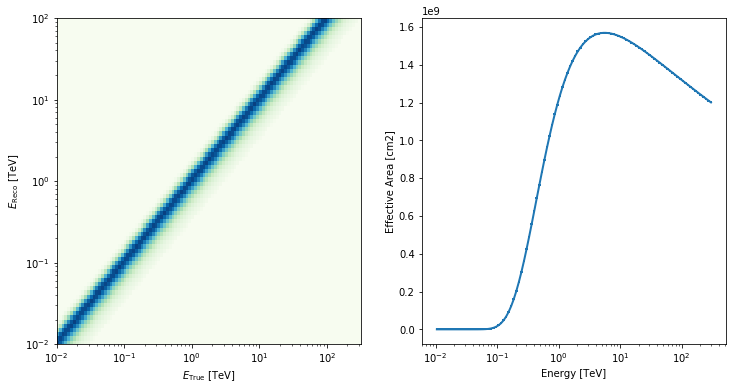

In [3]:
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2,2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2, bias=0)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
edisp.plot_matrix(ax=axes[0])
aeff.plot(ax=axes[1])

## Power law

In this section we will simulate one observation using a power law model.

In [4]:
index = 2.3
amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

pwl = PowerLaw(index=index, amplitude=amplitude, reference=reference)
print(pwl)

PowerLaw

Parameters: 

	   name     value   error       unit         min    max
	--------- --------- ----- --------------- --------- ---
	    index 2.300e+00   nan                       nan nan
	amplitude 1.000e-11   nan 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00   nan             TeV 0.000e+00 nan


In [5]:
livetime = 2 * u.h
sim = SpectrumSimulation(
    aeff=aeff,
    edisp=edisp,
    source_model=pwl,
    livetime=livetime,
)
sim.simulate_obs(seed=2309, obs_id=1)
print(sim.obs)

*** Observation summary report ***
Observation Id: 1
Livetime: 2.000 h
On events: 339
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 339.00
Excess / Background: inf
Gamma rate: 169.50 1 / h
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 0.01 TeV - 100.00 TeV


In [6]:
fit = SpectrumFit(obs_list=sim.obs, model=pwl.copy(), stat='cash')
fit.fit_range = [1, 10] * u.TeV
fit.fit()
fit.est_errors()
print(fit.result[0])

FCN = -74.05863550534 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 7.1149219641605896e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.25945,0.219135,0,0,,,
2,par_001_amplitude,0.925524,0.175427,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.259e+00 2.191e-01                       nan nan
	amplitude 9.255e-12 1.754e-12 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name           index               amplitude       reference
	--------- --------------------- --------------------- ---------
	    index   0.04802031980191156 2.983582917926233e-13       0.0
	amplitude 2.983582917926233e-13 3.077456871898623e-24       0.0
	reference                   0.0                   0.0       0.0 

Statistic: -74.059 (cash)
Fit Range: [1.         9.42668455] TeV



## Include background

In this section we will include a background component. Furthermore, we will also simulate more than one observation and fit each one individuallt in order to get average fit results.

In [7]:
bkg_index = 2.5
bkg_amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

bkg_model = PowerLaw(index=bkg_index, amplitude=bkg_amplitude, reference=reference)
alpha = 0.2

In [8]:
n_obs = 10
seeds = np.arange(n_obs)

sim = SpectrumSimulation(
    aeff=aeff,
    edisp=edisp,
    source_model=pwl,
    livetime=livetime,
    background_model=bkg_model,
    alpha=alpha,
)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

SpectrumObservationList
Number of observations: 10
*** Observation summary report ***
Observation Id: 0
Livetime: 2.000 h
On events: 733
Off events: 1915
Alpha: 0.200
Bkg events in On region: 383.00
Excess: 350.00
Excess / Background: 0.91
Gamma rate: 175.00 1 / h
Bkg rate: 0.04 1 / min
Sigma: 14.17
energy range: 0.01 TeV - 100.00 TeV


Before moving on to the fit let's have a look at the simulated observations

Text(0.5,0,'excess')

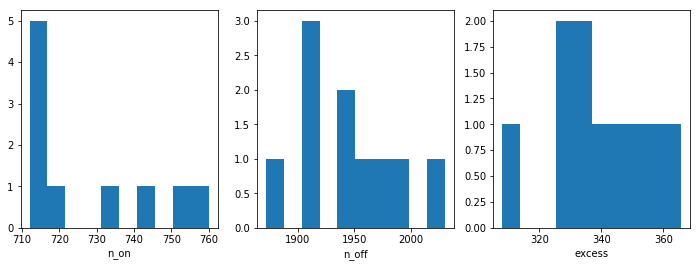

In [9]:
n_on = [obs.total_stats.n_on for obs in sim.result]
n_off = [obs.total_stats.n_off for obs in sim.result]
excess = [obs.total_stats.excess for obs in sim.result]

fix, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel('n_on')
axes[1].hist(n_off)
axes[1].set_xlabel('n_off')
axes[2].hist(excess)
axes[2].set_xlabel('excess')

In [10]:
# pwl.parameters['index'].max = 10

best_fit_index = []
for obs in sim.result:
    fit = SpectrumFit(obs, pwl.copy(), stat='wstat')
    fit.fit()
    best_fit_index.append(fit.result[0].model.parameters['index'].value)

FCN = 55.910801110317294 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 2.9520623012489907e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.42123,0.0843574,0,0,,,
2,par_001_amplitude,0.952219,0.0956807,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 74.3267447586923 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 1.9959808760087543e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.34851,0.0832151,0,0,,,
2,par_001_amplitude,1.03079,0.0965471,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 41.4710957506475 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 1.958631487248994e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.34515,0.0927654,0,0,,,
2,par_001_amplitude,0.89887,0.0941127,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 44.50018937564379 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 2.93676133213934e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.28489,0.0793548,0,0,,,
2,par_001_amplitude,0.998855,0.0935932,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 74.18812529859511 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 6.719612171184964e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.17087,0.0707336,0,0,,,
2,par_001_amplitude,1.18135,0.0940007,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 64.88320856820394 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 1.3701252257221275e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.16243,0.0684331,0,0,,,
2,par_001_amplitude,1.10582,0.0930451,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 60.67700677114248 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 3.588549972509129e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.36477,0.085037,0,0,,,
2,par_001_amplitude,0.958725,0.0942084,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 69.49768556957072 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 6.700769241452794e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.38486,0.0910636,0,0,,,
2,par_001_amplitude,0.978136,0.0991976,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 53.22728338561792 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 4.491194113553897e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.36911,0.0850907,0,0,,,
2,par_001_amplitude,0.934459,0.0944767,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


FCN = 62.9643092450745 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 9.850063704090934e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.18223,0.0734126,0,0,,,
2,par_001_amplitude,1.04035,0.0913069,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


best_fit_index: [2.4212253140855506, 2.3485109205519468, 2.3451535451974417, 2.284893915900598, 2.1708729055514686, 2.162428790564978, 2.36477096589781, 2.3848607280004783, 2.3691136323428577, 2.1822250194396067]


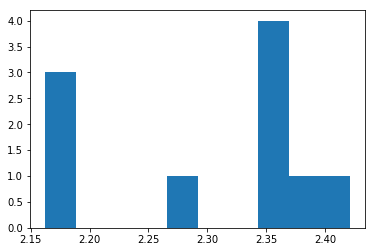

In [11]:
plt.hist(best_fit_index)
print('best_fit_index:', best_fit_index)

## Exercises

* Fit a pure power law and the user define model to the observation you just simulated. You can start with the user defined model described in the [spectrum_models.ipynb](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_models.ipynb) notebook.
* Vary the observation lifetime and see when you can distinguish the two models (Hint: You get the final likelihood of a fit from fit.result[0].statval).

## What's next

In this tutorial we learnd how to simulate and fit data using a toy detector. Go to [gammapy.spectrum](http://docs.gammapy.org/dev/spectrum/index.html) to see what else you can do with gammapy.